In [0]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
#from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn import metrics
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML

In [0]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
#sub = pd.read_csv('sample_submission.csv')
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [0]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [6]:
X.shape, X_test.shape, y.shape, 

((2845, 431), (2747, 431), (2845,))

# X is train data with 21973 raw data and 431 categolies, y is Fraud detection data, X_test is test data.


# There are 620 frauds in X(train data).

In [7]:
list(y ==1).count(True)

57

In [8]:
print('percent of fraud is', 620/21973*100)

percent of fraud is 2.821644745824421


In [9]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


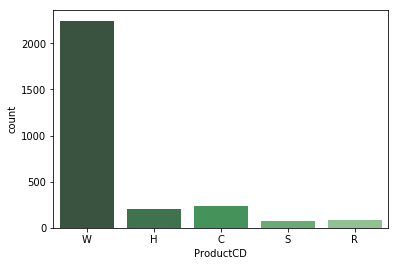

In [10]:
sns.countplot(x='ProductCD', data=X, palette='Greens_d')

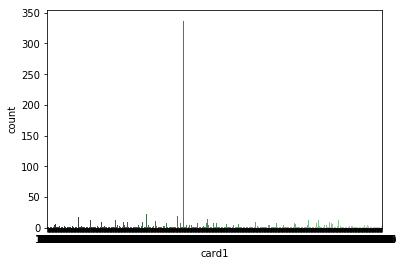

In [11]:
sns.countplot(x='card1', data=X, palette='Greens_d')

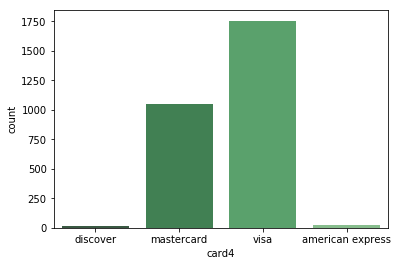

In [12]:
sns.countplot(x='card4', data=X, palette='Greens_d')

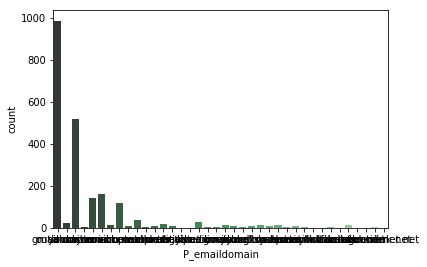

In [13]:
sns.countplot(x='P_emaildomain', data=X, palette='Greens_d')

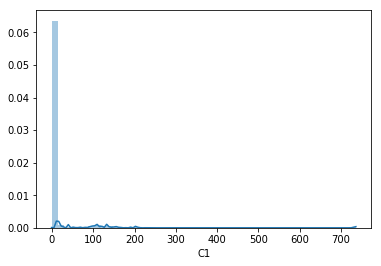

In [14]:
sns.distplot(X.C1,kde = True)

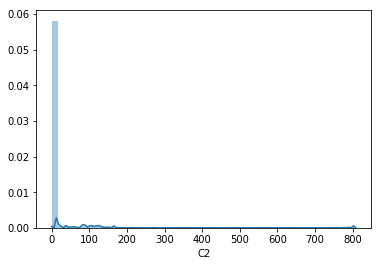

In [15]:
sns.distplot(X.C2,kde = True)

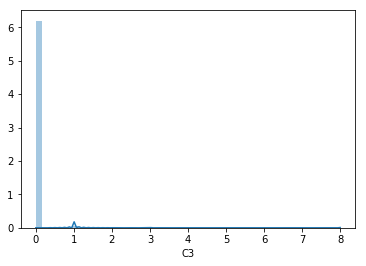

In [16]:
sns.distplot(X.C3,kde = True)

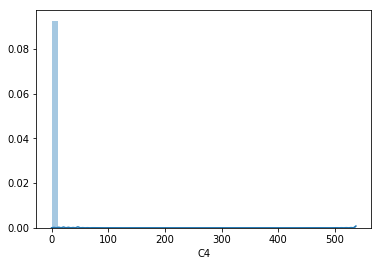

In [17]:
sns.distplot(X.C4,kde = True)

# Transform categorical data to number.

In [0]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(X[col].astype(str).values) + list(X_test[col].astype(str).values))
        X[col] = le.transform(list(X[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))  

In [24]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,...,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,708,281,6,1,4,0,22,0,19.0,21,13,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,0,1,1,2,0,...,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
1,29.0,4,1239,123,6,2,1,0,25,0,NaN,8,13,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
2,59.0,4,1407,188,6,3,10,1,27,0,287.0,26,13,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
3,50.0,4,1127,252,6,2,12,1,43,0,NaN,42,13,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,1,2,2,0,1,...,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
4,50.0,1,1387,209,6,2,1,0,33,0,NaN,8,13,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,100.0,1,10,4,1,1,6,8,79,67,9,3,2,3,2,4,1,1,1,34,59,1,19,2,1,0,1,1,1,99


# Remove the columns that have over 90% null cells.

In [25]:
many_null_cols = [col for col in X.columns if X[col].isnull().sum() / X.shape[0] > 0.9]
many_null_cols_test = [col for col in X_test.columns if X_test[col].isnull().sum() / X_test.shape[0] > 0.9]
cols_to_drop = list(set(many_null_cols + many_null_cols_test ))
len(cols_to_drop)

0

In [0]:
X = X.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

In [27]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,...,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,708,281,6,1,4,0,22,0,19.0,21,13,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,0,1,1,2,0,...,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
1,29.0,4,1239,123,6,2,1,0,25,0,NaN,8,13,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
2,59.0,4,1407,188,6,3,10,1,27,0,287.0,26,13,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
3,50.0,4,1127,252,6,2,12,1,43,0,NaN,42,13,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,1,2,2,0,1,...,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
4,50.0,1,1387,209,6,2,1,0,33,0,NaN,8,13,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,100.0,1,10,4,1,1,6,8,79,67,9,3,2,3,2,4,1,1,1,34,59,1,19,2,1,0,1,1,1,99


In [0]:
def normalize(X, cols):
    """
    Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    """
    for feature in cols:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X

In [33]:
normalize(X, ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C12', 'C13', 'C14'])

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,...,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.500,4,708,281,6,1,4,0,22,0,19.0,21,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.239437,-0.081409,2.0,-0.101519,-0.312491,-0.231241,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,0,1,1,2,0,...,0.0000,117.0000,0.0000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
1,29.000,4,1239,123,6,2,1,0,25,0,NaN,8,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.304542,-0.081409,1.0,-0.101519,-0.312491,-0.231241,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1,2,2,0,1,...,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
2,59.000,4,1407,188,6,3,10,1,27,0,287.0,26,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.239437,-0.081409,1.0,-0.101519,-0.312491,-0.231241,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,0,1,1,0,0,...,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
3,50.000,4,1127,252,6,2,12,1,43,0,NaN,42,13,-0.174785,-0.098198,-0.065185,-0.062949,-0.242221,-0.097479,-0.091774,-0.072096,-0.239437,-0.081409,1.0,-0.101519,-0.074794,-0.231241,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,1,2,2,0,1,...,50.0000,1404.0000,790.0000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
4,50.000,1,1387,209,6,2,1,0,33,0,NaN,8,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.018401,-0.304542,-0.020137,1.0,-0.101519,-0.312491,-0.231241,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,3,2,...,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0,70787.0,NaN,NaN,100.000000,1,10,4,1,1,6,8,79,67,9,3,2,3,2,4,1,1,1,34,59,1,19,2,1,0,1,1,1,99
5,49.000,4,101,242,6,3,25,1,17,0,36.0,8,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.239437,-0.081409,1.0,-0.101519,-0.312491,-0.231241,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0,1,1,1,0,...,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
6,159.000,4,540,84,6,3,10,1,23,0,0.0,42,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.239437,-0.081409,1.0,-0.101519,-0.312491,-0.231241,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0,1,1,0,0,...,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
7,422.500,4,587,188,6,3,25,1,25,0,NaN,18,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.304542,-0.081409,1.0,-0.101519,-0.312491,-0.231241,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1,2,2,0,0,...,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
8,15.000,1,1249,0,6,3,25,1,28,0,NaN,1,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.018401,-0.304542,-0.020137,1.0,-0.101519,-0.312491,-0.231241,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,3,2,...,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,-5.0,98945.0,0.0,-5.0,100.000000,1,4,1,1,1,6,8,87,50,9,3,2,3,2,4,1,1,1,31,44,1,43,1,1,0,0,1,1,29
9,117.000,4,1066,341,6,2,24,1,6,0,19.0,42,13,-0.174785,-0.160075,-0.065185,-0.062949,-0.242221,-0.126467,-0.091774,-0.072096,-0.109226,-0.081409,1.0,-0.101519,-0.203547,-0.195608,61.0,61.0,30.0,318.0,30.0,40.0,302.0,318.0,0,1,1,0,1,...,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN

In [0]:
# by https://www.kaggle.com/dimartinot
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

# Fill NaN by means value

In [0]:
X = X.fillna(X.mean())
X_test = X_test.fillna(X_test.mean())

In [36]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,...,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,4,708,281,6,1,4,0,22,0,19.000000,21,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.239437,-0.081409,2.0,-0.101519,-0.312491,-0.231241,14.0,181.211793,13.000000,151.819692,34.088889,13.000000,13.000000,0.000000,0,1,1,2,0,...,0.0,117.0,0.0,0.0,0.0,0.0,-7.115044,148722.124549,1.779439,-5.285981,99.55648,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
1,29.0,4,1239,123,6,2,1,0,25,0,117.133271,8,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.304542,-0.081409,1.0,-0.101519,-0.312491,-0.231241,0.0,181.211793,29.492201,0.000000,34.088889,0.000000,147.534161,0.000000,1,2,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,-7.115044,148722.124549,1.779439,-5.285981,99.55648,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
2,59.0,4,1407,188,6,3,10,1,27,0,287.000000,26,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.072096,-0.239437,-0.081409,1.0,-0.101519,-0.312491,-0.231241,0.0,181.211793,29.492201,0.000000,34.088889,0.000000,315.000000,315.000000,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7.115044,148722.124549,1.779439,-5.285981,99.55648,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
3,50.0,4,1127,252,6,2,12,1,43,0,117.133271,42,13,-0.174785,-0.098198,-0.065185,-0.062949,-0.242221,-0.097479,-0.091774,-0.072096,-0.239437,-0.081409,1.0,-0.101519,-0.074794,-0.231241,112.0,112.000000,0.000000,94.000000,0.000000,84.000000,147.534161,111.000000,1,2,2,0,1,...,50.0,1404.0,790.0,0.0,0.0,0.0,-7.115044,148722.124549,1.779439,-5.285981,99.55648,2,10,9,3,2,9,8,96,75,9,3,2,3,2,4,1,2,2,39,49,2,40,3,2,2,2,2,2,30
4,50.0,1,1387,209,6,2,1,0,33,0,117.133271,8,13,-0.196277,-0.180701,-0.065185,-0.062949,-0.242221,-0.184443,-0.091774,-0.018401,-0.304542,-0.020137,1.0,-0.101519,-0.312491,-0.231241,0.0,181.211793,29.492201,151.819692,34.088889,140.898764,147.534161,182.136856,1,2,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,70787.000000,1.779439,-5.285981,100.00000,1,10,4,1,1,6,8,79,67,9,3,2,3,2,4,1,1,1,34,59,1,19,2,1,0,1,1,1,99


## Split X data to train and test

In [0]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

In [0]:
a = splitter.split(X, y)

In [41]:
a

<generator object BaseShuffleSplit.split at 0x7f0d34fc5f10>

In [45]:
# Define the model
model = LogisticRegression()

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # Fit and predict!
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # And finally: show the results
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1394
           1       0.44      0.14      0.21        29

    accuracy                           0.98      1423
   macro avg       0.71      0.57      0.60      1423
weighted avg       0.97      0.98      0.97      1423



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
